# Problem

**State Space**

The state space consists of two discrete states:
$$
\mathcal{X} = \{0, 1\}.
$$

These can be interpreted as two different situations or system configurations, for instance, a “low-performance” state (0) and a “high-performance” state (1).

 **Action Space**

The action space consists of two discrete actions:
$$
\mathcal{A} = \{0, 1\}.
$$

These actions can be thought of as two control options available to the agent — for example:

* **Action 0**: Conservative or “stay” action (keeps the system near state 0)
* **Action 1**: Aggressive or “move” action (pushes the system toward state 1)

**Reward Function**

The reward is explicitly given by:
$$
r(x,a) = x + a.
$$

This means:
* Rewards increase with higher actions.
* Being in the “high” state (1) also provides additional reward.

**Transition Function**

Deterministic transition dynamics:

* If the agent takes **action 0**, it always transitions to state 0.
* If the agent takes **action 1**, it always transitions to state 1.

In tabular form:

| Current (x,a) | P(x′=0) | P(x′=1) |
| ------------- | ------- | ------- |
| (0,0)         | 1.0     | 0.0     |
| (0,1)         | 0.0     | 1.0     |
| (1,0)         | 1.0     | 0.0     |
| (1,1)         | 0.0     | 1.0     |

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import sys
from pathlib import Path

PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))
# Define dataset path
DATASET_PATH = PROJECT_ROOT / "datasets" / "dumb_problem.csv"

from fogas import FOGASSolverVectorized, FOGASOracleSolverVectorized, FOGASHyperOptimizer, FOGASEvaluator, PolicySolver

seed = 42

# Tabular Features

## Definition

**Feature Map** 

We use a one-hot feature representation over state–action pairs.  
Each feature corresponds to a unique \((x,a)\) combination.

The feature map is defined as:
$$
\phi(x,a) \in \mathbb{R}^4
$$

with the ordering:
$$
(0,0) \rightarrow e_0,\quad
(0,1) \rightarrow e_1,\quad
(1,0) \rightarrow e_2,\quad
(1,1) \rightarrow e_3
$$

**Reward Weights**

The reward function is linear in the features:
$$
r(x,a) = \phi(x,a)^\top \omega,
$$

with weight vector:
$$
\omega =
\begin{bmatrix}
0 \\
1 \\
1 \\
2
\end{bmatrix}.
$$

**Transition Weights**

The transition model is also linear in the features:
$$
p(x' \mid x,a) = \phi(x,a)^\top \psi(x').
$$

The transition weight vectors are:
$$
\psi(0) =
\begin{bmatrix}
1 \\
0 \\
1 \\
0
\end{bmatrix},
\quad
\psi(1) =
\begin{bmatrix}
0 \\
1 \\
0 \\
1
\end{bmatrix}.
$$


## Testing

In [2]:
states_2d = np.array([0, 1])
actions_2d = np.array([0, 1])
gamma_2d = 0.99
x_0 = 0 # fixed initial state

def phi(state, action):
    vec = np.zeros(4)
    vec[state * 2 + action] = 1.0
    return vec

omega = np.array([0, 1.0, 1.0, 2.0])

psi = {
    0: np.array([1.0, 0, 1.0, 0]),
    1: np.array([0, 1.0, 0, 1.0])
}


mdp = PolicySolver(states=states_2d, actions=actions_2d, phi=phi, omega=omega, gamma=gamma_2d, x0=x_0, psi=psi)

### Oracle vectorized

In [3]:
solver = FOGASOracleSolverVectorized(mdp=mdp, cov_matrix="identity", print_params=True, T=400)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"), seed=seed)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.0000
Num states N:             2
Num actions A:            2
Feature dim d:            4
Discount γ:               0.99
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      4627564.263195183
T (iterations):                400   (overridden → 400)

FOGAS Hyperparameters
---------------------
alpha:                        0.000294
rho:                            6.969724
eta:                            0.000024
D_theta:                    20.000000
beta (ridge):             0.000625
D_pi (derived):           2.354820





=== FOGAS Hyperparameter Optimization ===
[Initial] metric = -1.0040
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=1.2047e+00, rho=5.0000e+00, eta=2.4056e-05 | metric = -1.9899

Optimizing rho
[After rho*] alpha=1.2047e+00, rho=5.0000e+00, eta=2.4056e-05 | metric = -1.9899

Optimizing eta
[After eta*] alpha=1.2047e+00, rho=5.0000e+00, eta=8.2692e-02 | metric = -1.9900


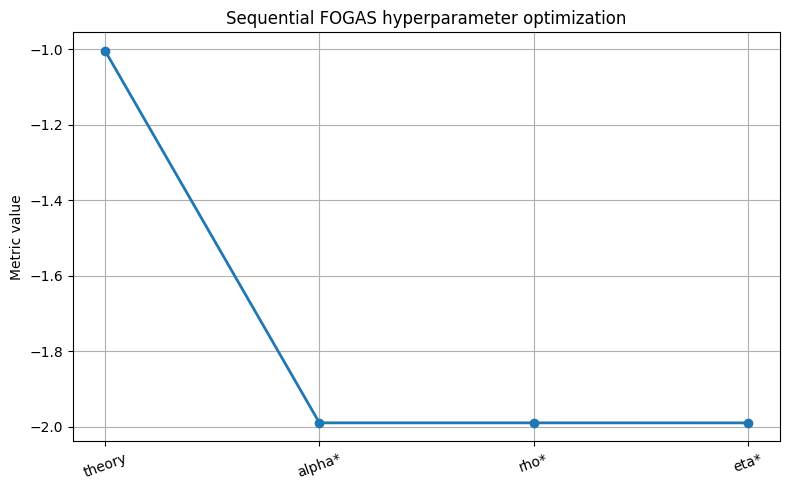

In [4]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]


In [5]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator.compare_value_functions()

FOGAS Oracle: 100%|██████████| 400/400 [00:00<00:00, 11121.71it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  199.000000 | V^π(x) =  198.999297 | Δ = -7.025165e-04
State 1: V*(x) =  200.000000 | V^π(x) =  199.999291 | Δ = -7.093924e-04

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  197.010000 | Q^π(x,a) =  197.009305 | Δ = -6.954914e-04
(x=0, a=1): Q*(x,a) =  199.000000 | Q^π(x,a) =  198.999298 | Δ = -7.022985e-04
(x=1, a=0): Q*(x,a) =  198.010000 | Q^π(x,a) =  198.009305 | Δ = -6.954914e-04
(x=1, a=1): Q*(x,a) =  200.000000 | Q^π(x,a) =  199.999298 | Δ = -7.022985e-04

Norm diagnostics:
||V^π - V*||_2 = 9.983822e-04
||Q^π - Q*||_2 = 1.397806e-03




### Empirical vectorized

In [6]:
solver_e = FOGASSolverVectorized(
    mdp=mdp, 
    print_params=True, 
    csv_path=str(DATASET_PATH)
)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(
    solver=solver_e,
    metric_callable=evaluator_e.get_metric("reward"),
    seed=seed
)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           100
Feature norm bound R:     1.0000
Num states N:             2
Num actions A:            2
Feature dim d:            4
Discount γ:               0.99
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      46.27564263195184
T (iterations):                47

FOGAS Hyperparameters
---------------------
alpha:                        0.000859
rho:                            1945.036816
eta:                            0.000070
D_theta:                    20.000000
beta (ridge):             0.005319
D_pi (derived):           0.807192




Trying same optimal hyperparameters found for the oracle.

In [7]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS: 100%|██████████| 47/47 [00:00<00:00, 9028.27it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  199.000000 | V^π(x) =  197.668517 | Δ = -1.331483e+00
State 1: V*(x) =  200.000000 | V^π(x) =  198.655068 | Δ = -1.344932e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  197.010000 | Q^π(x,a) =  195.691832 | Δ = -1.318168e+00
(x=0, a=1): Q*(x,a) =  199.000000 | Q^π(x,a) =  197.668517 | Δ = -1.331483e+00
(x=1, a=0): Q*(x,a) =  198.010000 | Q^π(x,a) =  196.691832 | Δ = -1.318168e+00
(x=1, a=1): Q*(x,a) =  200.000000 | Q^π(x,a) =  198.668517 | Δ = -1.331483e+00

Norm diagnostics:
||V^π - V*||_2 = 1.892535e+00
||Q^π - Q*||_2 = 2.649685e+00



========== FINAL REWARD COMPARISON ==========

J*(π*)   = 1.990000
J(π_FOGAS) = 1.976685
Gap (J* − J) = 1.331483e-02





=== FOGAS Hyperparameter Optimization ===
[Initial] metric = -1.2700
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=1.0000e+00, rho=1.0000e+00, eta=1.0000e-02 | metric = -1.9900

Optimizing rho
[After rho*] alpha=1.0000e+00, rho=8.7633e-01, eta=1.0000e-02 | metric = -1.9900

Optimizing eta
[After eta*] alpha=1.0000e+00, rho=8.7633e-01, eta=1.2152e-02 | metric = -1.9900


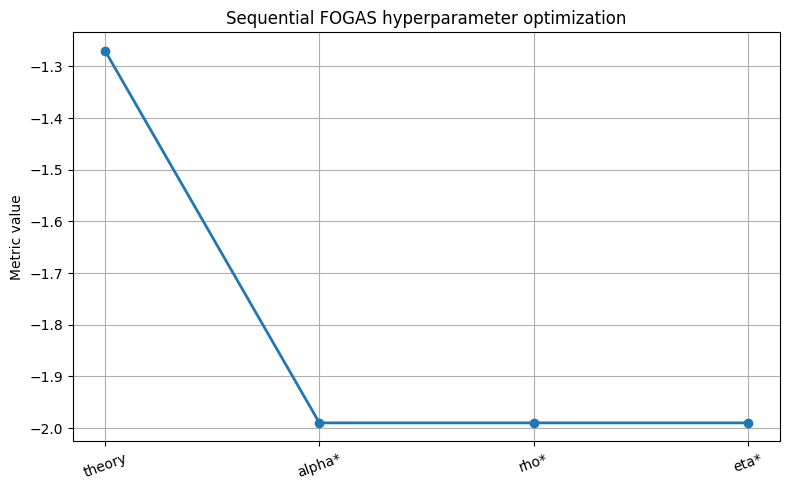

In [8]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=15,
    print_main=True, 
    print_search=False,
    num_runs=1,
    random_candidates=30,
    order=("alpha", "rho", "eta"),
    bounds_overrides={"alpha" : (1e-2, 1.0), "rho" : (1e-2, 1.0), "eta" : (1e-2, 1.0)}
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [9]:
solver_e.run(alpha=alpha_star_e, eta=eta_star_e, rho=rho_star_e, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS: 100%|██████████| 47/47 [00:00<00:00, 10060.34it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  199.000000 | V^π(x) =  199.000000 | Δ = -2.511663e-08
State 1: V*(x) =  200.000000 | V^π(x) =  200.000000 | Δ = -2.537033e-08

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  197.010000 | Q^π(x,a) =  197.010000 | Δ = -2.486547e-08
(x=0, a=1): Q*(x,a) =  199.000000 | Q^π(x,a) =  199.000000 | Δ = -2.511663e-08
(x=1, a=0): Q*(x,a) =  198.010000 | Q^π(x,a) =  198.010000 | Δ = -2.486547e-08
(x=1, a=1): Q*(x,a) =  200.000000 | Q^π(x,a) =  200.000000 | Δ = -2.511663e-08

Norm diagnostics:
||V^π - V*||_2 = 3.570012e-08
||Q^π - Q*||_2 = 4.998274e-08



========== FINAL REWARD COMPARISON ==========

J*(π*)   = 1.990000
J(π_FOGAS) = 1.990000
Gap (J* − J) = 2.511662e-10




# Funky Features

## Definition

**Feature Map**

The MDP follows the **Linear MDP assumption**, where both the reward and transition dynamics are linear in a known feature map $ \phi(x,a) $.

The feature representation is defined as:
$$
\phi(x,a) = 2 *
\begin{bmatrix}
1 \\
x \\
a
\end{bmatrix}
\in \mathbb{R}^3.
$$

**Reward Function**

The reward function is a linear combination of the feature vector:
$$
r(x,a) = \phi(x,a)^\top \omega,
$$
with the weight vector
$$
\omega = \frac{1}{2}
\begin{bmatrix}
0 \\
1 \\
1
\end{bmatrix}.
$$

**Transition Function**

The transition model is also linear in the features.
We define a collection of transition weight vectors $ \psi(x') $ such that
$$
p(x'|x,a) = \phi(x,a)^\top \psi(x').
$$

Specifically, the weights are:
$$
\psi(0) = \frac{1}{2}
\begin{bmatrix}
1 \\
0 \\
-1
\end{bmatrix}, \quad
\psi(1) = \frac{1}{2}
\begin{bmatrix}
0 \\
0 \\
1
\end{bmatrix}.
$$

## Testing

In [10]:
states_2d = np.array([0, 1])
actions_2d = np.array([0, 1])
gamma_2d = 0.99
x_0 = 0 # fixed initial state

def phi(state, action):
    return 2 * np.array([1.0, float(state), float(action)])

omega = np.array([0, 0.5, 0.5]) # reward depends on x and a

psi = {
    0: 0.5 * np.array([1.0, 0.0, -1.0]),  # transition weights for next state 0
    1: 0.5 * np.array([0.0, 0.0, 1.0])   # transition weights for next state 1
}

mdp = PolicySolver(states=states_2d, actions=actions_2d, phi=phi, omega=omega, gamma=gamma_2d, x0=x_0, psi=psi)

### Oracle vect

In [11]:
solver = FOGASOracleSolverVectorized(mdp=mdp, cov_matrix="identity", print_params=True, T=600)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"), seed=seed)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     3.4641
Num states N:             2
Num actions A:            2
Feature dim d:            3
Discount γ:               0.99
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      55530771.1583422
T (iterations):                600   (overridden → 600)

FOGAS Hyperparameters
---------------------
alpha:                        0.000080
rho:                            5.335644
eta:                            0.000008
D_theta:                    17.320508
beta (ridge):             0.006667
D_pi (derived):           0.832555




Only when changing orders: first eta!! It is the most important one here.


=== FOGAS Hyperparameter Optimization ===
[Initial] metric = -0.7045
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=8.0113e-05, rho=5.0000e+00, eta=7.5602e-06 | metric = -0.7045

Optimizing rho
[After rho*] alpha=8.0113e-05, rho=1.0000e-02, eta=7.5602e-06 | metric = -0.7045

Optimizing eta
[After eta*] alpha=8.0113e-05, rho=1.0000e-02, eta=3.0000e+00 | metric = -1.0404


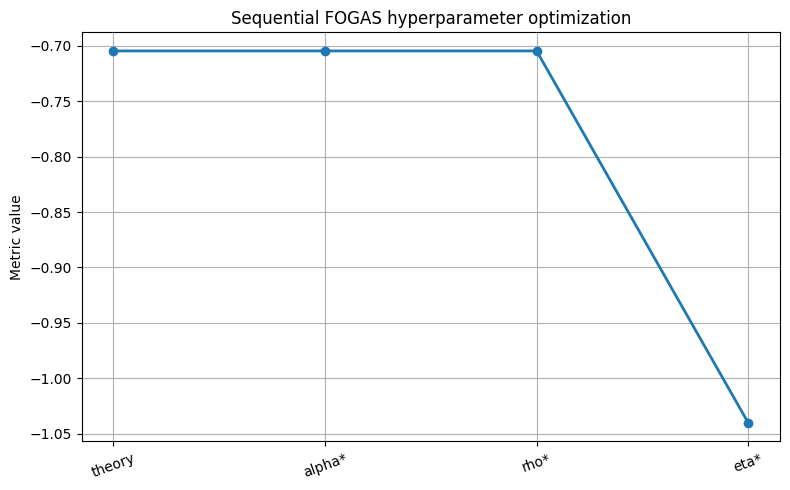

In [ ]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("eta", "rho", "alpha")
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [14]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator.compare_value_functions()

FOGAS Oracle: 100%|██████████| 600/600 [00:00<00:00, 11849.71it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  199.000000 | V^π(x) =  104.038929 | Δ = -9.496107e+01
State 1: V*(x) =  200.000000 | V^π(x) =  105.038929 | Δ = -9.496107e+01

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  197.010000 | Q^π(x,a) =  102.998539 | Δ = -9.401146e+01
(x=0, a=1): Q*(x,a) =  199.000000 | Q^π(x,a) =  104.988539 | Δ = -9.401146e+01
(x=1, a=0): Q*(x,a) =  198.010000 | Q^π(x,a) =  103.998539 | Δ = -9.401146e+01
(x=1, a=1): Q*(x,a) =  200.000000 | Q^π(x,a) =  105.988539 | Δ = -9.401146e+01

Norm diagnostics:
||V^π - V*||_2 = 1.342952e+02
||Q^π - Q*||_2 = 1.880229e+02




### Empirical

In [15]:
solver_e = FOGASSolverVectorized(
    mdp=mdp, 
    print_params=True, 
    csv_path=str(DATASET_PATH)
)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(
    solver=solver_e,
    metric_callable=evaluator_e.get_metric("reward"),
    seed=seed,
)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           100
Feature norm bound R:     3.4641
Num states N:             2
Num actions A:            2
Feature dim d:            3
Discount γ:               0.99
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      555.3077115834219
T (iterations):                556

FOGAS Hyperparameters
---------------------
alpha:                        0.000083
rho:                            1680.895969
eta:                            0.000008
D_theta:                    17.320508
beta (ridge):             0.007194
D_pi (derived):           0.801446




Trying same optimal hyperparameters found for the oracle.

In [16]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/556 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 556/556 [00:00<00:00, 10660.53it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  199.000000 | V^π(x) =  103.478909 | Δ = -9.552109e+01
State 1: V*(x) =  200.000000 | V^π(x) =  104.478909 | Δ = -9.552109e+01

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  197.010000 | Q^π(x,a) =  102.444120 | Δ = -9.456588e+01
(x=0, a=1): Q*(x,a) =  199.000000 | Q^π(x,a) =  104.434120 | Δ = -9.456588e+01
(x=1, a=0): Q*(x,a) =  198.010000 | Q^π(x,a) =  103.444120 | Δ = -9.456588e+01
(x=1, a=1): Q*(x,a) =  200.000000 | Q^π(x,a) =  105.434120 | Δ = -9.456588e+01

Norm diagnostics:
||V^π - V*||_2 = 1.350872e+02
||Q^π - Q*||_2 = 1.891318e+02



========== FINAL REWARD COMPARISON ==========

J*(π*)   = 1.990000
J(π_FOGAS) = 1.034789
Gap (J* − J) = 9.552109e-01





=== FOGAS Hyperparameter Optimization ===
[Initial] metric = -0.8829
Order: ('eta', 'rho', 'alpha')

Optimizing eta
eta=7.853601200740478e-06, metric=-0.8828644815011517
eta=1.5447602177163683e-05, metric=-0.9390826679946792
eta=3.0384584972485432e-05, metric=-0.9809565135870866
eta=5.976480966832469e-05, metric=-1.0049106088191004
eta=0.0001175540978402544, metric=-1.017496481305185
eta=0.00023122245340906962, metric=-1.0240809829171484
eta=0.00045480186520730203, metric=-1.0276194659133182
eta=0.0008945702873851061, metric=-1.0300627855991138
eta=0.0017595706180921432, metric=-1.0325220753067315
eta=0.0034609787556249593, metric=-1.0329623232536107
eta=0.006807555106753897, metric=-1.0315360136825678
eta=0.013390086967789795, metric=-1.0285908424995658
eta=0.0263375655713889, metric=-1.024229555120987
eta=0.051804544802124444, metric=-1.0186868311451627
eta=0.10189669409198152, metric=-1.0129494551638847
eta=0.20042520027024907, metric=-1.0081666204507889
eta=0.3942253599229423, met

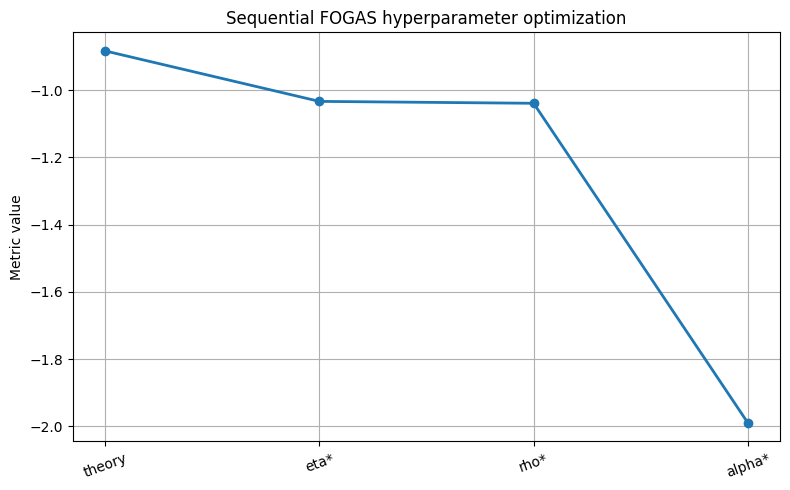

In [18]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_search=True,
    print_main=True, 
    num_runs=2,
    order=("eta", "rho", "alpha")
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [19]:
solver_e.run(alpha=alpha_star_e, eta=eta_star_e, rho=rho_star_e, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/556 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 556/556 [00:00<00:00, 9137.27it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  199.000000 | V^π(x) =  199.000000 | Δ =  1.307399e-12
State 1: V*(x) =  200.000000 | V^π(x) =  200.000000 | Δ =  1.278977e-12

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  197.010000 | Q^π(x,a) =  197.010000 | Δ =  1.307399e-12
(x=0, a=1): Q*(x,a) =  199.000000 | Q^π(x,a) =  199.000000 | Δ =  1.278977e-12
(x=1, a=0): Q*(x,a) =  198.010000 | Q^π(x,a) =  198.010000 | Δ =  1.307399e-12
(x=1, a=1): Q*(x,a) =  200.000000 | Q^π(x,a) =  200.000000 | Δ =  1.278977e-12

Norm diagnostics:
||V^π - V*||_2 = 1.828954e-12
||Q^π - Q*||_2 = 2.586532e-12



========== FINAL REWARD COMPARISON ==========

J*(π*)   = 1.990000
J(π_FOGAS) = 1.990000
Gap (J* − J) = -1.310063e-14


